# Grabage Image Classification App

NOTE: In this data set, the number of classes is low and there is an unbalanced data set.

## Imports

In [1]:
import keras
import tensorflow as tf

from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#!pip uninstall tf-keras
# !pip install tensorflow==2.16.1

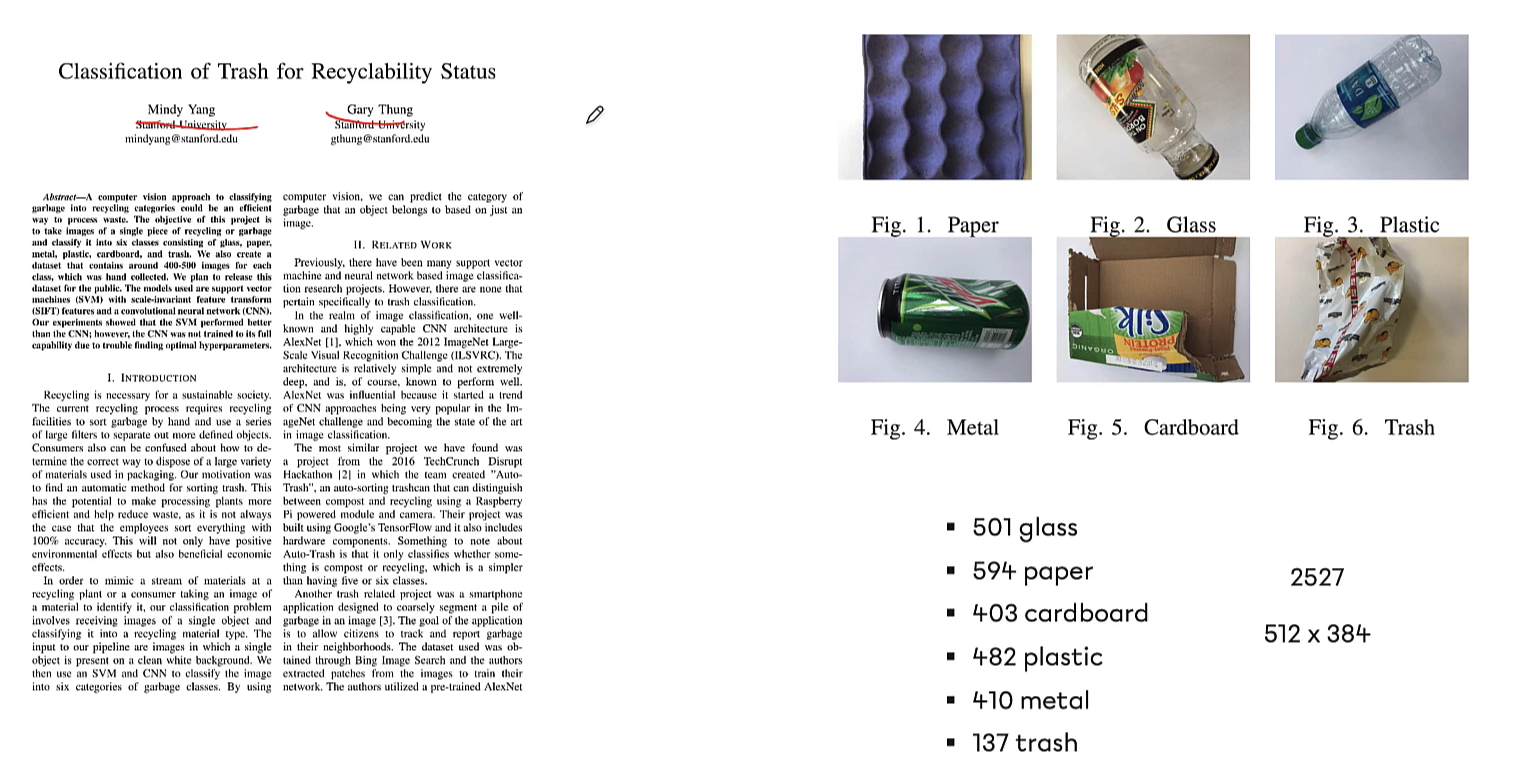

## Functions

In [3]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
        
    plt.tight_layout()
    plt.show()

## Data Understanding

In [4]:
dir_path = "../Garbage classification"
img_list = get_image_paths(dir_path)

print(len(img_list))

2527


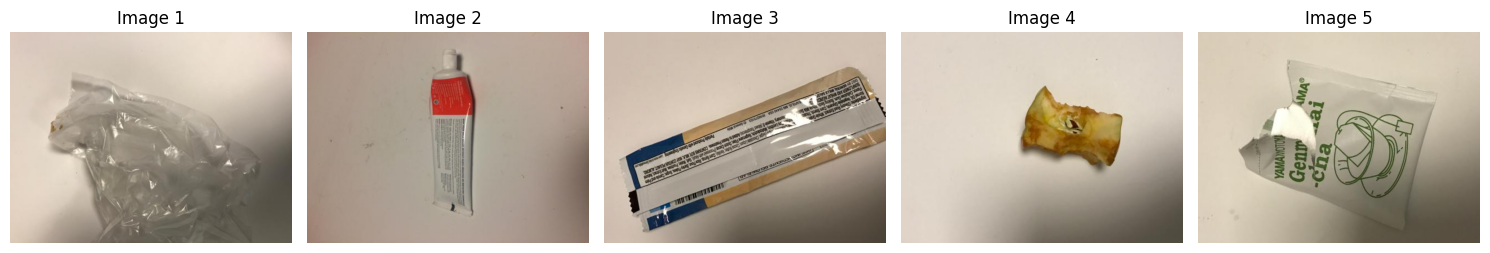

In [5]:
display_images(img_list[0:5])

## Data Preparation & Augmentation

In [6]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1, # Since the number of observations/data in our dataset is low, we made 10% of it validation_set.
                         rescale=1./255, # It transforms from 0-255 to 0-1. It is a MinMax scaler.
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [7]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224), # As a result, 224x224 pixel images will be produced.
                                          batch_size=32,
                                          class_mode='categorical', 
# It indicates that classes are marked categorically. It produces one-hot encoded class for each class.
# If we wrote "binary", class labels would be 1 or 0. If we wrote "sparse", class labels would be expressed as integer. 
# If we had a large number of classes, sparse could be used, but many cost functions are also compatible with the one-hot encoded class format.
# Generally, "categorical" is preferred.
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=251, # We used all the data in the validation set because the data is small.
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [8]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]


## Model

In [9]:
model = Sequential([
    layers.Input(shape=(224, 224, 3)), # As input information, we gave information as 224x224 pixels and 3 channels.
    layers.Conv2D(32, (3, 3), activation='relu'),
    #Conv2D() => It is used to add a convolution layer in Keras. We say add 32 3x3 kernels. There will be 32 "feature-maps" as output.
    # These 32 filters are applied to each color channel. Therefore, each filter is a 3x3x3 tensor.
    layers.MaxPooling2D((2, 2)),
    # MaxPooling2D() => we add pooling to the first layer. A 2x2 pooling matrix is used.
    layers.Conv2D(64, (3, 3), activation='relu'),
    # AS THE LAYERS GET DEEPER, THE NUMBER OF KERNEL (FILTERS) USED IS INCREASED. BECAUSE,
    # THIS NUMBER SHOULD INCREASE AS MORE COMPLEX FEATURE EXTRACTIONS WILL BE MADE IN DEEP LAYERS.
    # It went from 32 to 64! Therefore, our number of "feature-maps" is also increasing.
    layers.MaxPooling2D((2, 2)),    
    layers.Conv2D(128, (3, 3), activation='relu'),
    # Kernel Number increased from 64 to 128! Multiples of 2 in the form of 2^n are common in practical use as the number of kernels.
    layers.Flatten(), # Added pre-ANN data flattening layer.
    # -- ANN Part --
    # A hidden layer with 128 neurons was added to learn the weights of features. Dropout, BatchNormalization etc.
    # layers can also be added, but our focus right now is CNN!
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])


metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)]

# The loss parameter determined which type we would apply the optimization function to.
# We inform you that the outputs are not passed through one-hot encoding.
# In one-hot encoding, the class information would be [0, 0, 1, 0, ...] instead of 3, and in this case the sparse statement would be gone 
# and "categorical_crossentropy" would have to be used.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)
# If the DEPENDENT (Target) VARIABLE is a scalar number, this situation is called SPARSE CODING. There is 1 single numeric value for each label.
# If the dependent variable is like this, parameter names like "sparse_categorical_...." are used.

early_stopping = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='garbage_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False, # saving all of the model.
                             verbose=1)

In [11]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=5,
                    # epochs=100
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3111 - auc: 0.6305 - loss: 1.6254 
Epoch 1: val_loss improved from inf to 1.41006, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1074s 15s/step - accuracy: 0.3116 - auc: 0.6310 - loss: 1.6247 - val_accuracy: 0.4303 - val_auc: 0.7714 - val_loss: 1.4101
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4206 - auc: 0.7702 - loss: 1.3767
Epoch 2: val_loss improved from 1.41006 to 1.28750, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.4210 - auc: 0.7705 - loss: 1.3761 - val_accuracy: 0.4582 - val_auc: 0.8317 - val_loss: 1.2875
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5335 - auc: 0.8289 - loss: 1.2273
Epoch 3: val_loss improved from 1.28750 to 1.26453, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.5335 - auc: 0.8287 - loss: 1.2278 - val_accuracy: 0.5219 - val_auc: 0.8398 - val_loss: 1.2645
Epoc

## Model Performance Plot

In [12]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

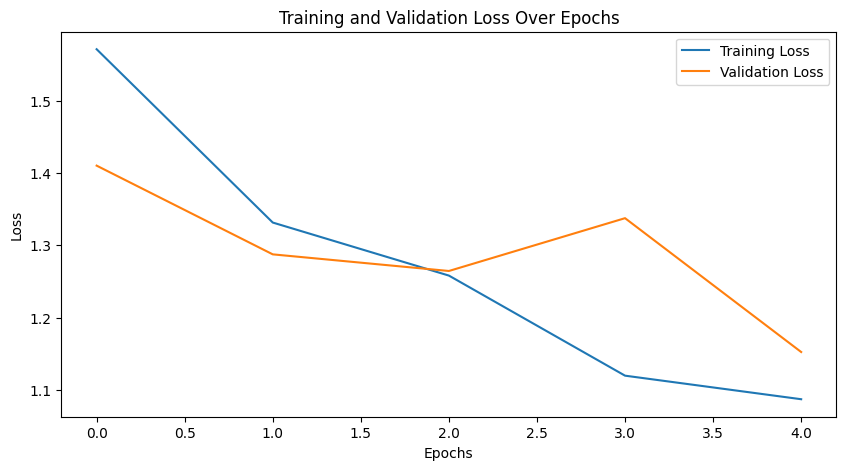

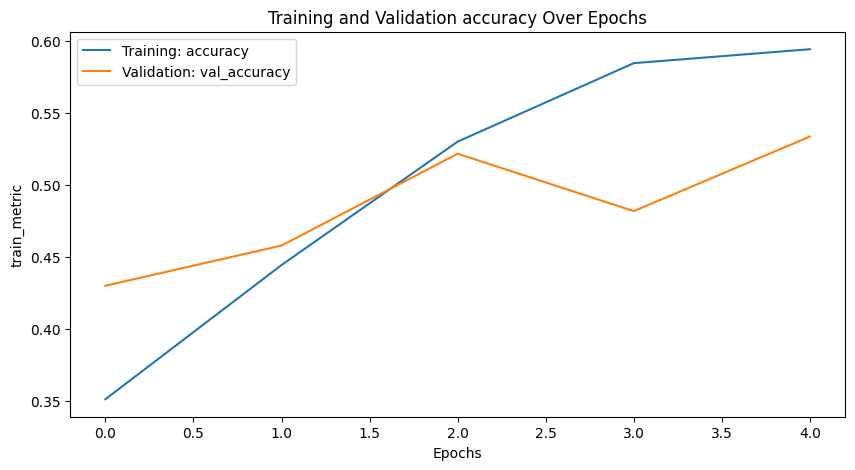

In [13]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

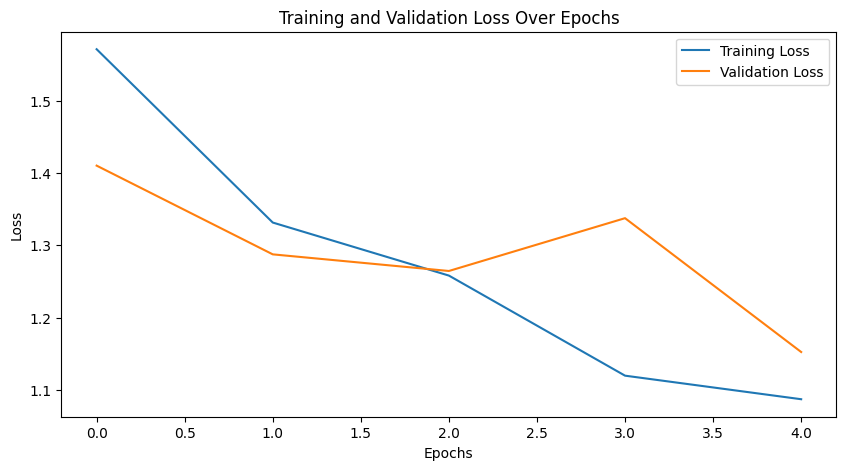

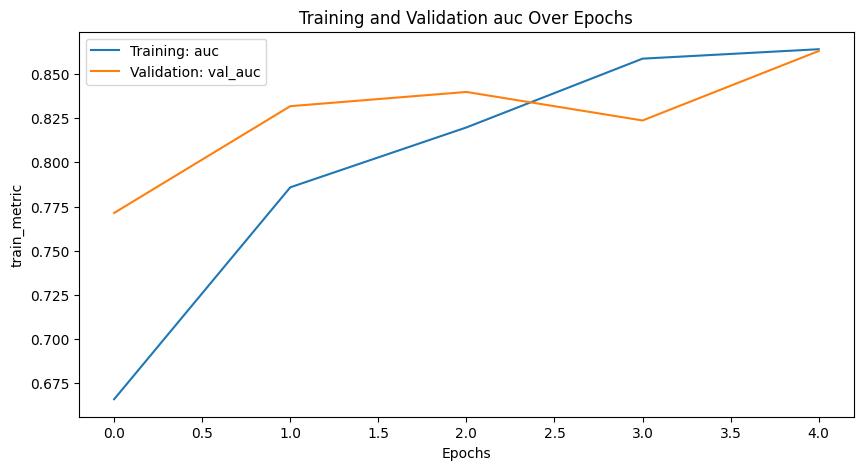

In [14]:
plot_training_history(history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

## Model Performance Numeric

In [15]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 1.1525901556015015
Accuracy: 0.5338645577430725
AUC: 0.8629345893859863


# Prediction

In [16]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

im_dir = "../Garbage classification"

images_paths = [im_dir + "/metal/metal10.jpg", im_dir + "/glass/glass104.jpg", im_dir + "/plastic/plastic100.jpg", im_dir + "/trash/trash103.jpg"]

garbage_model = load_model('/content/garbage_model.keras')

In [17]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

def prediction_probs(img_array, model, waste_labels):

    predictions = model.predict(img_array, verbose = 0)

    predicted_class_idx = np.argmax(predictions[0]) # I took the index value of the highest prediction from the prediction results.

    predicted_class = waste_labels.get(predicted_class_idx, 'Unknown') 
    # If the predicted value is not indexed in the waste labels dict, it sets the predicted_class to "Unknow".

    max_probability = np.max(predictions[0])

    return max_probability, predicted_class

def display_images(image_paths, model, waste_labels):
    # dynamic display
    num_images = len(image_paths)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 5, num_rows * 5))

    for i, path in enumerate(image_paths):
        img, img_array = preprocess_image(path)

        probability, predicted_class = prediction_probs(img_array, model, waste_labels)

        ax = plt.subplot(num_rows, num_cols, i + 1)
        img = image.img_to_array(img)
        plt.imshow(img.astype('uint8'))
        plt.title(f"Max Probability: {probability:.2f}\nPredicted Class: {predicted_class}")
        plt.axis('off')
    plt.show()

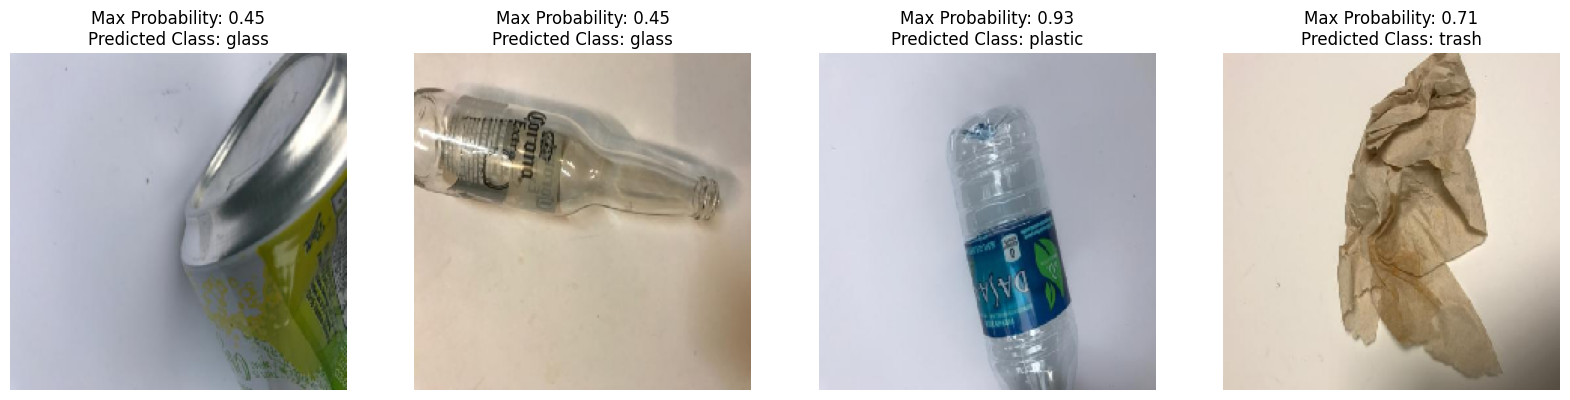

In [18]:
display_images(images_paths, garbage_model, waste_labels)

In [19]:
get_image_paths(im_dir, 10)

['/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/paper/paper308.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/metal/metal146.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/cardboard/cardboard172.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/paper/paper455.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/glass/glass139.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/paper/paper173.jpg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/Garbage classification/glass/glass325.jpg',
 '/content/drive/MyDrive/Colab Notebooks

In [ ]:
random_images_path = get_image_paths(im_dir, 10)
display_images(random_images_path, garbage_model, waste_labels)